# Graded Lab: Monitoring, Diagnosis and Interventions in Production

Welcome to this assignment!

Carefully read each Markdown (text) cell, which include instructions and hints. Start by reading the background behind your upcoming tasks.

When you are done, submit your solution by saving it, then clicking on the submit button at the top right side of the page.

## In order for your submission to be graded correctly, you **MUST**:
* **Use the provided variable names**, otherwise the autograder will not be able to locate the variable for grading. 

* **Replace any instances of `None` with your own code.** 

* **Only modify the cells that start with the comment `# GRADED CELL`**.  

* **Use the provided cells for your solution.** You can add new cells to experiment, but these will be omitted when grading. 

To submit your solution, save it, then click on the blue submit button at the top of the page.

<div style="background-color: #FAD888; padding: 10px; border-radius: 3px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1); width:95%
">
<strong>Important notes</strong>:

- Code blocks with None will not run properly. If you run them before completing the exercise, you will likely get an error. 

- The notebooks work best in Chrome browser. If you are having problems, please switch to Chrome.

- Make sure you always save before submitting.
</div>

## Introduction

In this lab, you will
1. Explore a simulated production log dataset (`csbot_production_logs.csv`).  
2. Define and visualize monitoring metrics (latency, token usage, error rates, satisfaction).  
3. Diagnose and cluster failure cases.  
4. Map problems to the right optimization interventions.

# Objectives

You will implement a complete production monitoring and intervention pipeline for LLM systems by analyzing real production logs, computing key performance metrics, diagnosing failure patterns, and mapping problems to appropriate optimization strategies. Through hands-on exercises, you'll learn to build robust monitoring systems that can detect issues early and guide targeted improvements.

* **Compute Production Monitoring Metrics:** Calculate essential performance indicators including latency percentiles, token usage, error rates, and user satisfaction scores from production log data.
* **Implement Alert Threshold Checking:** Build an alerting system that compares computed metrics against predefined thresholds and generates human-readable alert messages for production issues.
* **Extract Failure Cases from Production Logs:** Define and identify failure cases based on user satisfaction scores, explicit negative feedback, and critical system errors to focus improvement efforts.
* **Categorize Issues Using Heuristic Rules:** Implement rule-based classification to group failure cases into actionable categories like verbosity, politeness, knowledge gaps, and format errors for targeted interventions.

## Table of Contents

- [Setup](#setup)
- [Data Exploration](#dataexploration)
- [Monitoring Metrics](#monitor) - Exercise 1, 2
- [Issue Diagnosis & Clustering](#issue) - Exercise 3, 4
- [Intervention Strategies](#interventionstrategies)
- [Summary](#summary)


## Setup <a id="setup"></a>

As usual, start by importing the necessary packages. Here you also define a function to run tests.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def run_test(func, *args):
    try:
        func(*args)
        print(f"✅ {func.__name__} passed")
        return True
    except AssertionError as e:
        print(f"❌ {func.__name__} failed:", e)
        return False
    
    print("✅ Setup complete. All required packages are available.")

## Data Exploration <a id="dataexploration"></a>

You will investigate the structure of production logs for an LLM-based system to detect missing or noisy values and think about their impact on downstream monitoring. You will also build intuition about **user feedback distribution** (satisfaction & thumbs) and **error type frequencies**.  

In [2]:
# Load dataset
logs = pd.read_csv("/app/data/csbot_production_logs.csv")

# Preview first 5 rows
logs.head()

,request_id,timestamp,intent,user_prompt,llm_response,response_time_ms,tokens_generated,error_type,user_satisfaction,thumbs_up
0,1,2025-09-01T09:00:00,inventory,Is the 13-inch ultrabook in stock?,Policy last updated in 2023: please refer to t...,2400,686,knowledge_outdated,2,-1
1,2,2025-09-01T09:00:20,return_policy,Can I return an item I bought last week?,"Dear valued customer, thank you so much for re...",3400,2591,NaN,2,-1
2,3,2025-09-01T09:00:40,return_policy,What's your return policy?,"{slots: [2025-09-02T10:00:00Z, 2025-09-02T14:0...",1700,509,json_format_error,1,0
3,4,2025-09-01T09:01:00,inventory,Do you have PS5 available?,Inventory varies by location; the item is low ...,900,303,NaN,5,1
4,5,2025-09-01T09:01:20,structured,"Provide JSON schema: policy, window_days, rest...","{""product"":""USB-C charger"",""price"":19.99,""in_s...",900,386,NaN,5,1


Before you dive into analysis, understand **what information this dataset contains** and why it matters.

The production logs include the following key columns:

- **timestamp** — when the request happened. Useful for time-based trends.
- **prompt / llm_response** — the user's query and the model's reply. This helps connect metrics to real examples.
- **latency_ms** — how long the model took to respond (in milliseconds).
  - **average latency** measures typical performance.
  - **p95 latency** (95th percentile) shows "worst-case" delays that real users may experience.
- **tokens_generated** — how many tokens the model produced.
  - Tracking the **distribution of token usage** tells if responses are too long (which increases cost and slows down serving).
- **error_type** — system-detected issues (e.g., malformed JSON, outdated knowledge, style problems).
  - From this you can compute **error rates** for each type, which show reliability problems.
- **satisfaction / thumbs_up** — direct user feedback.
  - **Satisfaction scores** (1–5) show overall user experience.
  - **Thumbs up/down** gives a quick binary indicator of good vs bad responses.

In [3]:
# Inspect dataset
logs.info()
logs.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   request_id         120 non-null    int64 
 1   timestamp          120 non-null    object
 2   intent             120 non-null    object
 3   user_prompt        120 non-null    object
 4   llm_response       120 non-null    object
 5   response_time_ms   120 non-null    int64 
 6   tokens_generated   120 non-null    int64 
 7   error_type         27 non-null     object
 8   user_satisfaction  120 non-null    int64 
 9   thumbs_up          120 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 9.5+ KB


,request_id,timestamp,intent,user_prompt,llm_response,response_time_ms,tokens_generated,error_type,user_satisfaction,thumbs_up
count,120.000000,120,120,120,120,120.000000,120.000000,27,120.000000,120.000000
unique,NaN,120,11,41,18,NaN,NaN,2,NaN,NaN
top,NaN,2025-09-01T09:00:00,inventory,Do you have PS5 available?,"Dear valued customer, thank you so much for re...",NaN,NaN,json_format_error,NaN,NaN
freq,NaN,1,18,10,24,NaN,NaN,15,NaN,NaN
mean,60.500000,NaN,NaN,NaN,NaN,1790.000000,876.458333,NaN,3.258333,0.033333
std,34.785054,NaN,NaN,NaN,NaN,920.850904,742.096937,NaN,1.469556,0.859288
min,1.000000,NaN,NaN,NaN,NaN,900.000000,263.000000,NaN,1.000000,-1.000000
25%,30.750000,NaN,NaN,NaN,NaN,1200.000000,450.000000,NaN,2.000000,-1.000000
50%,60.500000,NaN,NaN,NaN,NaN,1200.000000,560.500000,NaN,4.000000,0.000000
75%,90.250000,NaN,NaN,NaN,NaN,2400.000000,755.500000,NaN,5.000000,1.000000


Next, **check data quality**.  
- Are there any missing values in key fields like `prompt`, `llm_response`, or `satisfaction`?
- If you find missing values, how should you handle them (drop rows, fill with defaults, etc.)?

In [4]:
# Missing values check
logs.isnull().sum()

request_id            0
timestamp             0
intent                0
user_prompt           0
llm_response          0
response_time_ms      0
tokens_generated      0
error_type           93
user_satisfaction     0
thumbs_up             0
dtype: int64

Now look at **user feedback**.  
- How are satisfaction scores distributed (1–5)?  
- How often do users give a thumbs up, thumbs down, or no rating?  

user_satisfaction
1    15
2    36
3     8
4    25
5    36
Name: count, dtype: int64
thumbs_up
-1    42
 0    32
 1    46
Name: count, dtype: int64


array([[<Axes: title={'center': 'user_satisfaction'}>,
        <Axes: title={'center': 'thumbs_up'}>]], dtype=object)

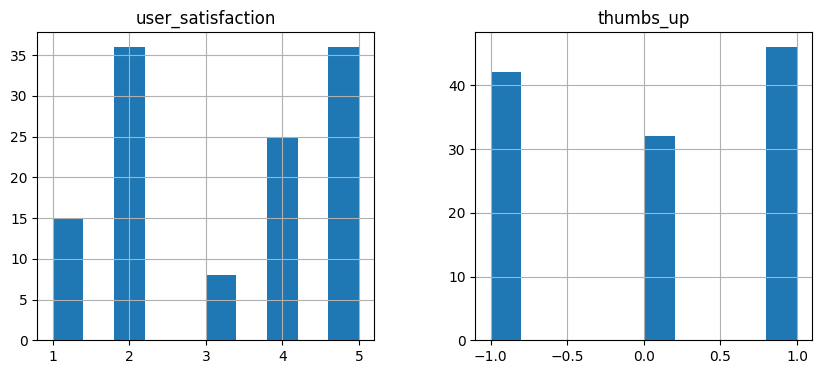

In [5]:
# Satisfaction & Thumbs distribution
print(logs['user_satisfaction'].value_counts().sort_index())
print(logs['thumbs_up'].value_counts().sort_index())

logs[['user_satisfaction','thumbs_up']].hist(figsize=(10,4))

Check the **error_type column** to understand what kinds of problems occur.  
Examples:  
- `knowledge_outdated` (model gave old or wrong info)  
- `json_format_error` (invalid output format)  
- `too_verbose` (answer too long)  
- `too_polite` (style issue)  

In [6]:
# Error type frequency
logs['error_type'].replace("", "none").value_counts()

error_type
json_format_error     15
knowledge_outdated    12
Name: count, dtype: int64

Finally, look at a few **real examples** of prompts, responses, and feedback.  
Reading raw examples helps connect metrics (like satisfaction score) with actual user experience.  
This step builds intuition about **why** users like or dislike certain responses.

In [7]:
# Sample inspection
sample_low_sat = logs[logs['user_satisfaction'] <= 2].head(5)[['user_prompt','llm_response','error_type','user_satisfaction','thumbs_up']]
sample_low_sat

,user_prompt,llm_response,error_type,user_satisfaction,thumbs_up
0,Is the 13-inch ultrabook in stock?,Policy last updated in 2023: please refer to t...,knowledge_outdated,2,-1
1,Can I return an item I bought last week?,"Dear valued customer, thank you so much for re...",NaN,2,-1
2,What's your return policy?,"{slots: [2025-09-02T10:00:00Z, 2025-09-02T14:0...",json_format_error,1,0
6,Where is my order #126225?,"Dear valued customer, thank you so much for re...",NaN,2,0
7,How to reset my router bought from you?,Policy last updated in 2023: please refer to t...,knowledge_outdated,2,0


## Monitoring Metrics <a id="monitor"></a>

Load the production logs. If `logs` is already in memory, this cell will not overwrite it.

In [8]:
# Try Customer Service Bot dataset first
try:
    logs
except NameError:
    try:
        logs = pd.read_csv("/app/data/csbot_production_logs.csv")
    except FileNotFoundError:
        print("Note: data file lost, please reset your environment")
        exit(1)

display(logs.head())
print(f"Rows: {len(logs)} | Columns: {list(logs.columns)}")

,request_id,timestamp,intent,user_prompt,llm_response,response_time_ms,tokens_generated,error_type,user_satisfaction,thumbs_up
0,1,2025-09-01T09:00:00,inventory,Is the 13-inch ultrabook in stock?,Policy last updated in 2023: please refer to t...,2400,686,knowledge_outdated,2,-1
1,2,2025-09-01T09:00:20,return_policy,Can I return an item I bought last week?,"Dear valued customer, thank you so much for re...",3400,2591,NaN,2,-1
2,3,2025-09-01T09:00:40,return_policy,What's your return policy?,"{slots: [2025-09-02T10:00:00Z, 2025-09-02T14:0...",1700,509,json_format_error,1,0
3,4,2025-09-01T09:01:00,inventory,Do you have PS5 available?,Inventory varies by location; the item is low ...,900,303,NaN,5,1
4,5,2025-09-01T09:01:20,structured,"Provide JSON schema: policy, window_days, rest...","{""product"":""USB-C charger"",""price"":19.99,""in_s...",900,386,NaN,5,1


Rows: 120 | Columns: ['request_id', 'timestamp', 'intent', 'user_prompt', 'llm_response', 'response_time_ms', 'tokens_generated', 'error_type', 'user_satisfaction', 'thumbs_up']


Convert the string `timestamp` column to a datetime column `ts`.  
This is required for time-series visualizations later.

In [9]:
from utils.util import parse_timestamps

logs = parse_timestamps(logs)

Create a normalized error column `_error_norm` where empty strings are mapped to `"none"`.
This makes error counting robust and consistent.

In [10]:
from utils.util import normalize_errors

logs = normalize_errors(logs)
print(logs["_error_norm"])

0      knowledge_outdated
1                    none
2       json_format_error
3                    none
4                    none
              ...        
115                  none
116                  none
117                  none
118                  none
119                  none
Name: _error_norm, Length: 120, dtype: object


### Exercise 1: Compute Production Monitoring Metrics

Compute and return a dictionary with:
- `avg_latency_ms`, `p95_latency_ms`
- `avg_tokens`
- `error_rate_pct`
- `avg_satisfaction`

In [11]:
# GRADED CELL: exercise 1

def compute_metrics(df: pd.DataFrame) -> dict:
    """
    Compute monitoring metrics:
      - avg_latency_ms, p95_latency_ms, avg_tokens, error_rate_pct, avg_satisfaction
    Returns a dict of floats rounded to 2 decimals.
    """
    ## START CODE HERE ###
    # avg_latency is the average of response_time_ms, use .mean() to calculate the average
    avg_latency = df['response_time_ms'].mean()

    # p95_latency is the 95th percentile of response_time_ms, use np.percentile() to calculate the 95th percentile
    p95_latency = np.percentile(df['response_time_ms'], 95)

    # avg_tokens is the average of tokens_generated, use .mean() to calculate the average
    avg_tokens = df['tokens_generated'].mean()

    # error_rate is the percentage of rows where _error_norm is not "none"
    error_rate = (df['_error_norm'] != "none").mean() * 100

    # avg_satisfaction is the average of user_satisfaction, use .mean() to calculate the average
    avg_satisfaction = df['user_satisfaction'].mean()
    ## END CODE HERE ###
    return {
        "avg_latency_ms": float(round(avg_latency, 2)),
        "p95_latency_ms": float(round(p95_latency, 2)),
        "avg_tokens": float(round(avg_tokens, 2)),
        "error_rate_pct": float(round(error_rate, 2)),
        "avg_satisfaction": float(round(avg_satisfaction, 2)),
    }

metrics = compute_metrics(logs)
for k, v in metrics.items():
    print(f"{k}: {v}")

avg_latency_ms: 1790.0
p95_latency_ms: 3400.0
avg_tokens: 876.46
error_rate_pct: 22.5
avg_satisfaction: 3.26


Unit Test: `compute_metrics` Implementation

In [12]:
from utils.unit_tests import test_compute_metrics_returns_keys, test_compute_metrics_reasonable_ranges

run_test(test_compute_metrics_returns_keys, logs, compute_metrics)
run_test(test_compute_metrics_reasonable_ranges, logs, compute_metrics)

✅ test_compute_metrics_returns_keys passed
✅ test_compute_metrics_reasonable_ranges passed


True

Create functions to visualize different monitoring metrics.  

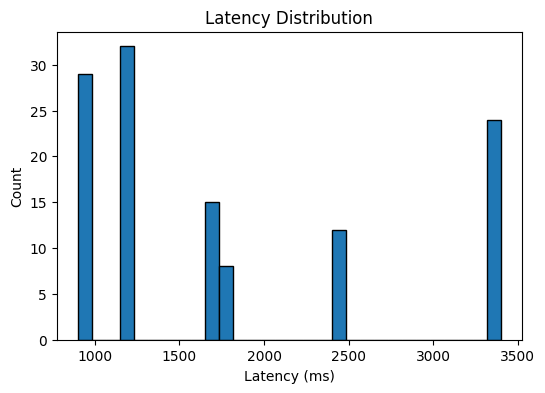

In [13]:
from utils.util import plot_latency_distribution
plot_latency_distribution(logs)

You have already prepared plotting functions for the other metrics (`satisfaction`, `tokens`, and `error types`) inside **`utils.util.py`**.  

👉 Your job here is not to re-implement them, but to **use these utilities** to quickly generate the plots and focus on **interpreting the results**.  
 
- **Token usage distribution** → shows if responses are too short/too long (cost & efficiency).  
- **Error type distribution** → highlights the most common failure modes (reliability).  

In the next cells, you'll call these ready-made functions and practice **explaining what the plots mean** in a production monitoring context.

Use the provided `plot_token_distribution(df)` function to visualize how many tokens the model usually generates per response.

👉 **Your task:**  
- Look at the distribution. Do you see **two peaks** (bimodal distribution)?  
- What might this mean? For example:  
  - Some responses are short and efficient.  
  - Others are very long (possibly too verbose), which may increase latency and cost.  

✅ **Key takeaway:**  
Unusual clusters in token usage can indicate inconsistent model behavior that might need intervention (e.g., RL tuning for brevity).
    

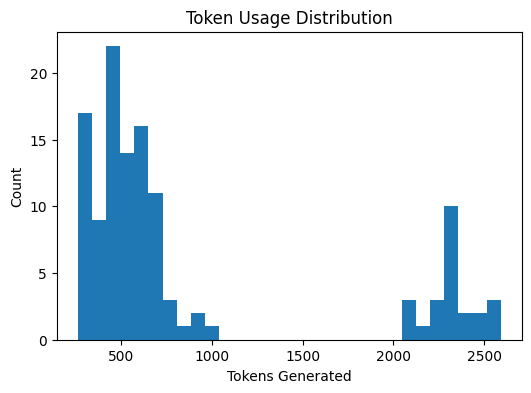

In [14]:
from utils.util import plot_token_distribution
plot_token_distribution(logs)

Use the provided `plot_error_types(df)` function to check which error types are most common.

- Which error type occurs most frequently?  
- What could be the impact of each error type in production? For example:  
  - `json_format_error`: breaks downstream systems expecting structured output.  
  - `knowledge_outdated`: gives users wrong info, reduces trust.  

Error distribution highlights the **reliability bottlenecks** of your system. The most frequent error type should be the first target for intervention.

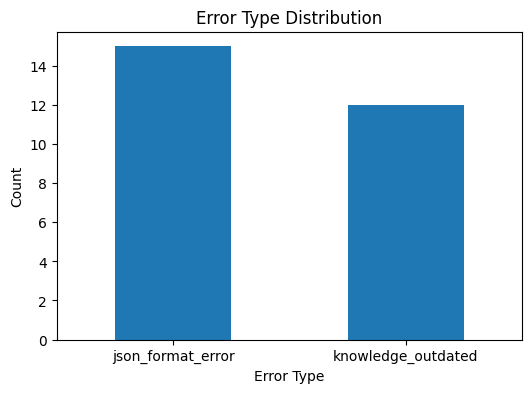

In [15]:
from utils.util import plot_error_types
plot_error_types(logs)

### Exercise 2: Implement Alert Threshold Checking

Compare metrics to thresholds and return a list of human-readable alert strings.
Rules:
- Trigger if metric > threshold for: `avg_latency_ms`, `p95_latency_ms`, `error_rate_pct`, `avg_tokens`
- Trigger if `avg_satisfaction` < `avg_satisfaction_min` (already implemented)

In [17]:
# GRADED CELL: exercise 2

ALERT_THRESHOLDS = {
    "avg_latency_ms": 3000,     # Alert if average latency > 3000 ms
    "p95_latency_ms": 5000,     # Alert if P95 latency > 5000 ms
    "error_rate_pct": 25.0,      # Alert if error rate > 5%
    "avg_tokens": 1200,         # Investigate verbosity if avg tokens > 1200
    "avg_satisfaction_min": 3.0 # Alert if avg satisfaction < 3.0
}

def check_alerts(metrics: dict, thresholds: dict) -> list:
    """
    Return list of strings describing which alerts are triggered.
    """
    triggered = []
    ### START CODE HERE ###
    # Higher-is-worse metrics
    for key in ["avg_latency_ms", "p95_latency_ms", "error_rate_pct", "avg_tokens"]:
        # check if the key is in both metrics and thresholds and if metrics[key] is larger than thresholds[key]
        if key in metrics and key in thresholds and metrics[key] > thresholds[key]:
            t = f"{key}: {metrics[key]} > {thresholds[key]}" 
            triggered.append(t) 
    ### END CODE HERE ###
    
    # Lower-is-worse for satisfaction
    sat_min = thresholds.get("avg_satisfaction_min")
    if sat_min is not None and "avg_satisfaction" in metrics and metrics["avg_satisfaction"] < sat_min:
        # check if metrics['avg_satisfaction'] is less than sat_min
        t =  f"avg_satisfaction: {metrics['avg_satisfaction']} < {sat_min}"
        triggered.append(t)
    
    return triggered

In [18]:
print(metrics)
alerts = check_alerts(metrics, ALERT_THRESHOLDS)
print("\n=== Alert Check ===")
if not alerts:
    print("No alerts triggered ✅")
else:
    print("Alerts triggered ❗")
    for a in alerts:
        print(" -", a)

{'avg_latency_ms': 1790.0, 'p95_latency_ms': 3400.0, 'avg_tokens': 876.46, 'error_rate_pct': 22.5, 'avg_satisfaction': 3.26}

=== Alert Check ===
No alerts triggered ✅


Unit Test: `check_alerts` Implementation

In [19]:
from utils.unit_tests import test_check_alerts_high_is_worse, test_check_alerts_low_is_worse_satisfaction

run_test(test_check_alerts_high_is_worse, check_alerts)
run_test(test_check_alerts_low_is_worse_satisfaction, check_alerts)

✅ test_check_alerts_high_is_worse passed
✅ test_check_alerts_low_is_worse_satisfaction passed


True

## Issue Diagnosis & Clustering <a id="issue"></a>

Monitoring metrics (latency, token usage, satisfaction, errors) only tell us **when something is wrong**,  
but not **what exactly is wrong**.

To debug real-world LLMs, you need to define **failure cases** and then cluster them into meaningful categories.  

### Exercise 3: Extract Failure Cases from Production Logs

**Failure case definition**:  
- `user_satisfaction <= 2`, OR  
- `thumbs_up == -1` (explicit thumbs down), OR  
- `error_type` in {`knowledge_outdated`, `json_format_error`}

Filter the dataset based on the failure definition and inspect the size and ratio of failure cases.

In [20]:
# GRADED CELL: exercise 3

def extract_failure_cases(logs):
    ## START CODE HERE ###
    # Define three conditions for failure cases
    # Condition 1: Low user satisfaction (1-2 indicates dissatisfaction)
    low_satisfaction = logs['user_satisfaction'] <= 2
    
    # Condition 2: Explicit negative user feedback (thumbs down), expressed as thumbs_up equals -1
    negative_feedback = logs['thumbs_up'] == -1
    
    # Condition 3: System-detected critical errors (error_type is either knowledge_outdated or json_format_error)
    critical_errors = logs['error_type'].isin(['knowledge_outdated', 'json_format_error'])
    
    ## END CODE HERE ###

    # Combine all failure conditions (any condition being true marks it as a failure case)
    failure_df = logs[
        low_satisfaction | negative_feedback | critical_errors
    ].copy()
    return failure_df

print(f"Total logs: {len(logs)}")
failure_df = extract_failure_cases(logs)
print(f"Failure cases: {len(failure_df)} ({len(failure_df)/len(logs)*100:.2f}%)")
failure_df.head()

Total logs: 120
Failure cases: 56 (46.67%)


,request_id,timestamp,intent,user_prompt,llm_response,response_time_ms,tokens_generated,error_type,user_satisfaction,thumbs_up,ts,_error_norm
0,1,2025-09-01T09:00:00,inventory,Is the 13-inch ultrabook in stock?,Policy last updated in 2023: please refer to t...,2400,686,knowledge_outdated,2,-1,2025-09-01 09:00:00,knowledge_outdated
1,2,2025-09-01T09:00:20,return_policy,Can I return an item I bought last week?,"Dear valued customer, thank you so much for re...",3400,2591,NaN,2,-1,2025-09-01 09:00:20,none
2,3,2025-09-01T09:00:40,return_policy,What's your return policy?,"{slots: [2025-09-02T10:00:00Z, 2025-09-02T14:0...",1700,509,json_format_error,1,0,2025-09-01 09:00:40,json_format_error
6,7,2025-09-01T09:02:00,order_status,Where is my order #126225?,"Dear valued customer, thank you so much for re...",3400,2216,NaN,2,0,2025-09-01 09:02:00,none
7,8,2025-09-01T09:02:20,tech_support,How to reset my router bought from you?,Policy last updated in 2023: please refer to t...,2400,726,knowledge_outdated,2,0,2025-09-01 09:02:20,knowledge_outdated


### Exercise 4: Categorize Issues Using Heuristic Rules

Apply simple rules to label failure cases:  
- `too_verbose`: tokens > threshold (e.g., 1500)  
- `too_polite`: response contains ["thank you", "thanks", "apolog", "sincerely", "appreciate"] phrases  
- `knowledge_outdated`: `error_type == knowledge_outdated`  
- `json_malformed`: `error_type == json_format_error`  
- `other`: none of the above  

In [21]:
# GRADED CELL: exercise 4

def categorize_issue(row, verbose_token_threshold=1500):
    etype = str(row.get("error_type", "")).strip()
    text = str(row.get("llm_response", "")).lower()
    tokens = int(row.get("tokens_generated", 0))
    ## START CODE HERE ###
    # write if else statements to categorize the issue based on the row
    if etype == "json_format_error": # @KEEP
        return "json_malformed" 
    # If error type is knowledge_outdated, return "knowledge_outdated"
    if etype == "knowledge_outdated":
        return "knowledge_outdated"
    # If number of tokens exceeds the verbose_token_threshold, return "too_verbose"
    if tokens > verbose_token_threshold:
        return "too_verbose"
    # If the text includes any of the polite words, return "too_polite"
    polite_words = ["thank you", "thanks", "apolog", "sincerely", "appreciate"] 
    if any(word in text for word in polite_words):
        return "too_polite"
    # If none of the above trigger, return "other"
    return "other"
    ## END CODE HERE ###

failure_df["failure_cluster"] = failure_df.apply(categorize_issue, axis=1)
print(failure_df["failure_cluster"].value_counts())

failure_cluster
too_verbose           24
json_malformed        15
knowledge_outdated    12
too_polite             5
Name: count, dtype: int64


Semantic Clustering (Optional, Advanced)

Use **SentenceTransformer** to embed `user_prompt + llm_response (+ error_type)` and cluster failure cases into groups. This can reveal hidden patterns beyond heuristic rules.

In [22]:
from utils.util import semantic_cluster_failure_cases
failure_df, info = semantic_cluster_failure_cases(
    failure_df,
    model_name="all-MiniLM-L6-v2",
    k_range=(2, 6),
    use_error_hints=True,
    label_col="semantic_cluster",
)

print("Chosen k:", info["k"])
print("Embeddings shape:", info["emb_shape"])
print("Embedding backend:", info["model"])
print(failure_df["semantic_cluster"].value_counts().sort_index())

✅ Loading pre-downloaded model from: /app/models/sentence-transformers/all-MiniLM-L6-v2
🔄 Computing embeddings...
✅ Embeddings computed: shape (56, 384)
Chosen k: 3
Embeddings shape: (56, 384)
Embedding backend: sentence-transformers
semantic_cluster
0    13
1    24
2    19
Name: count, dtype: int64


Compare **heuristic categories** (`failure_cluster`) with **semantic clusters** (`semantic_cluster`).

You will create a simple **crosstab** to see how many cases from each heuristic class fall into each semantic cluster.

👉 Look for patterns like:
- Does one semantic cluster mostly correspond to `too_verbose`?
- Are `json_malformed` cases concentrated in a single cluster?
- Do `too_polite` cases mix with others?

In [23]:
# Simple Crosstab
if "semantic_cluster" not in failure_df.columns:
    print("No `semantic_cluster` found. Run Step 3 (Semantic Clustering) first.")
else:
    # Crosstab: rows = heuristic classes, columns = semantic cluster IDs
    ct = pd.crosstab(failure_df["failure_cluster"], failure_df["semantic_cluster"])
    print("=== Crosstab: failure_cluster × semantic_cluster ===")
    display(ct)

    # Quick dominant mapping (which semantic cluster each heuristic class falls into most)
    dominant = ct.idxmax(axis=1).to_dict()
    print("\nHeuristic → dominant semantic cluster mapping:")
    for heur, sem in dominant.items():
        print(f"  {heur} → cluster {sem}")

=== Crosstab: failure_cluster × semantic_cluster ===


semantic_cluster,0,1,2
failure_cluster,,,
json_malformed,0,0,15
knowledge_outdated,8,0,4
too_polite,5,0,0
too_verbose,0,24,0



Heuristic → dominant semantic cluster mapping:
  json_malformed → cluster 2
  knowledge_outdated → cluster 0
  too_polite → cluster 0
  too_verbose → cluster 1


## Intervention Strategies <a id="interventionstrategies"></a>

From your error diagnosis, you identified four major failure types.  
Each of them connects to a **specific optimization technique** in post-training or production workflows:

| Failure Type        | Problem Nature            | Optimization Technique                         | Why this works |
|---------------------|---------------------------|------------------------------------------------|----------------|
| **knowledge_outdated** | Knowledge freshness issue | **RAG (Retrieval-Augmented Generation)**       | Model itself cannot stay up-to-date. RAG lets us plug in fresh knowledge (FAQ, policies, docs) without retraining. |
| **json_malformed**  | Reliability / format error | **Guardrails / Schema enforcement**            | Ensure outputs respect strict formats (e.g., JSON schema, function calling). Prevents malformed responses in production. |
| **too_verbose**     | Preference misalignment    | **RL preference tuning / Prompt brevity control** | Users want concise answers. RLHF/DPO can optimize for brevity, or prompts can set max tokens / penalties. |
| **too_polite**      | Style / tone preference    | **Prompt/template adjustments / RL tone tuning** | Over-apologizing or being overly polite reduces usefulness. Prompt templates or RL fine-tuning align tone with user needs. |

Different problems require different tools.  
You cannot fix knowledge freshness with RL, and you cannot fix malformed JSON with RAG.  

Below are some failure cases. Use the dropdowns to select the **best optimization technique** for each case.

In [24]:
from utils.util import create_intervention_selector

# Create interactive intervention selector
create_intervention_selector()

Case 1: The bot gives a very long-winded answer to a simple FAQ.


Dropdown(description='Your choice:', index=3, layout=Layout(width='70%'), options=('RAG update', 'Guardrails /…

Case 2: The bot outputs invalid JSON that breaks downstream parsers.


Dropdown(description='Your choice:', index=1, layout=Layout(width='70%'), options=('RAG update', 'Guardrails /…

Case 3: The bot apologizes three times in one short answer.


Dropdown(description='Your choice:', index=2, layout=Layout(width='70%'), options=('RAG update', 'Guardrails /…

Case 4: The bot still cites an old return policy from last year.


Dropdown(description='Your choice:', layout=Layout(width='70%'), options=('RAG update', 'Guardrails / Schema e…

Button(button_style='success', description='Submit All Choices', layout=Layout(margin='20px 0', width='200px')…

Output()

Now imagine you are the **production owner**.  
Given limited engineering resources, which optimization would you prioritize **first** for deployment?

Use the dropdown below to make your choice.

In [25]:
from utils.util import create_priority_decision_selector

# Create priority decision selector
create_priority_decision_selector()

Dropdown(description='Choose intervention:', layout=Layout(width='80%'), options=('RAG update (fix knowledge f…

Button(description='Submit Choice', style=ButtonStyle())

Output()

## Summary <a id="summary"></a>

In this lab, you experienced the **end-to-end cycle of production model optimization**:

This cycle doesn’t stop — real-world LLM systems require continuous **monitoring, diagnosis, interventions, and iteration** to stay reliable and aligned with user needs.

<p align="center">
  <img src="images/a32ebfb0-2c64-42d7-9028-b97b53d81eb7.png" alt="Production Loop" width="400"/>
</p>